## Fale com um EBM sobre a evasão estudantil na UPE


In [6]:
import pandas as pd
import textwrap
from sklearn.model_selection import train_test_split

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import t2ebm
import joblib
from pathlib import Path

# auto-reload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Carregue o dataset evasao_UPE.csv e treine um EBM


In [7]:
df = pd.read_csv("dados/evasao_UPE.csv", sep=';', decimal=',')

# Colunas de identificação e a probabilidade pré-calculada são removidas para evitar vazamento do alvo
cols_to_drop = ["Aluno", "ID do Aluno", "Disciplina", "ID da Disciplina", "PROBABILIDADE"]
df_model = df.drop(columns=cols_to_drop)

# pandas to numpy array
X_data = df_model.drop(columns=["EVASAO"]).values
y_data = df_model["EVASAO"].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

df_model.head()


,Curso,Semestre,Periodo,Data de Início,Data de Final,var01,var02,var03,var10,var11,...,var16,var17,var18,var19,var20,var21,var26,var27,var29,EVASAO
0,Pedagogia,2010.2,1,1277942400,1293839999,5.15,33,43,9.29,1.27,...,33,75,0,69,1,0,25,11,4,0
1,Pedagogia,2010.2,1,1277942400,1293839999,1.54,12,8,2.43,0.04,...,1,39,0,36,0,0,25,11,4,0
2,Pedagogia,2010.2,1,1277942400,1293839999,0.31,5,0,1.00,0.04,...,1,4,1,4,0,1,25,11,4,1
3,Pedagogia,2010.2,1,1277942400,1293839999,2.65,26,21,4.78,0.38,...,10,56,0,50,0,0,25,11,4,0
4,Pedagogia,2010.2,1,1277942400,1293839999,2.12,16,20,4.63,0.15,...,4,48,0,41,0,0,25,11,4,0


In [8]:
feature_names = df_model.drop(columns=["EVASAO"]).columns.tolist()

model_path = Path("dados/ebm_upe.joblib")
model_loaded = model_path.exists()

if model_loaded:
    ebm = joblib.load(model_path)
    print(f"Modelo carregado de {model_path}")
else:
    ebm = ExplainableBoostingClassifier(interactions=0, 
                                        feature_names=feature_names)
    ebm.fit(X_train, y_train)
    model_path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(ebm, model_path)
    print(f"Modelo treinado e salvo em {model_path}")

ebm_score = ebm.score(X_test, y_test)
ebm_score


Modelo treinado e salvo em dados/ebm_upe.joblib


0.9872276483846731

In [9]:
show(ebm.explain_global()) # visualize the EBM

<!-- http://127.0.0.1:7001/139755067298576/ -->

### High-Level API: passe o EBM direto para o LLM


##### Pedir ao LLM que descreva um gráfico do modelo


In [10]:
graph_description = t2ebm.describe_graph('gpt-5-nano-2025-08-07', ebm, 0, language="Portuguese (Brazil)") # feature 0, 'Curso'
print(textwrap.fill(graph_description, 80))


BadRequestError: Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.7 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}

In [ ]:
graph_description = t2ebm.describe_graph('gpt-5-nano-2025-08-07', ebm, 9, language="Portuguese (Brazil)") # feature 9, 'var11'
print(textwrap.fill(graph_description, 80))


INFO: The graph of feature var11 was simplified by 0.1%.
The graph from the Generalized Additive Model (GAM) for the continuous feature
"var11" depicts a complex, non-linear relationship with the response variable.
Initially, the model predicts a positive effect on the response as "var11"
ranges from 0.0 to about 0.25, peaking at a value of 3.94. Surprisingly, there
is a sharp transition to negative values around 0.48, where the mean response
plummets to -3.83, indicating a possible threshold effect that drastically
alters the behavior of the system being modeled. This negative trend intensifies
as "var11" increases, stabilizing at deeply negative values from -17.28 onwards,
reaching lows of up to -17.7 in the highest ranges (4.02 to 11.42). The
confidence intervals across the graph are relatively narrow, suggesting high
confidence in the model’s predictions, though they widen slightly as values
become more negative. This pattern could suggest threshold effects, cumulative
adverse impa

##### Dar mais contexto ao LLM com a descrição do dataset e do alvo


In [7]:
dataset_description = """Este notebook usa um conjunto de dados de evasão estudantil da UPE. Cada linha representa o histórico de um(a) aluno(a) em uma disciplina em um semestre específico. As colunas incluem o curso (Pedagogia ou Licenciatura em Computação), semestre/período, datas de início e finalização, e variáveis numéricas (var01, var02, var03, var10, var11, var12, var13, var16, var17, var18, var19, var20, var21, var26, var27, var29) com métricas derivadas do desempenho acadêmico e engajamento. As colunas de identificação e a probabilidade pré-computada foram removidas antes do treino para evitar vazamento. O alvo EVASAO é binário: 1 indica que o(a) aluno(a) abandonou, e 0 indica que permaneceu ativo(a)."""

graph_description = "O eixo y mostra as contribuições em log-odds para a chance de evasão (probabilidade de EVASAO = 1)."


In [ ]:
graph_description = t2ebm.describe_graph('gpt-5-nano-2025-08-07', 
                                          ebm,
                                          0, 
                                          graph_description=graph_description,
                                          dataset_description=dataset_description,
                                          language="Portuguese (Brazil)")
print(textwrap.fill(graph_description, 80))


The graph represents the influence of the categorical feature "Curso" (Course)
on the log-odds of student dropout at UPE, analyzed through a Generalized
Additive Model (GAM). It includes two courses: "Biologia" (Biology) and
"Pedagogia" (Pedagogy). The Biology course shows a significant negative
contribution to dropout likelihood, with a mean effect of -2.563 and a
confidence interval ranging from -3.675 to -1.45. Contrarily, the Pedagogy
course exhibits a positive effect on dropout likelihood with a mean of 0.543 and
a confidence interval from 0.307 to 0.779. This pattern is somewhat
counterintuitive as courses with rigorous academic demands like Biology might be
expected to have higher dropout rates. Instead, the data suggests stronger
retention in Biology compared to Pedagogy, possibly indicating the impact of
department-specific support systems, student motivations, or curriculum
engagement. Understanding these dynamics is crucial for targeted interventions
and improving student re

In [ ]:
graph_description = t2ebm.describe_graph('gpt-5-nano-2025-08-07', 
                                          ebm,
                                          9, 
                                          graph_description=graph_description,
                                          dataset_description=dataset_description,
                                          language="Portuguese (Brazil)")
print(textwrap.fill(graph_description, 80))


INFO: The graph of feature var11 was simplified by 0.1%.
The graph depicts the influence of the continuous feature "var11" on a dependent
variable, likely related to student dropout likelihood, as analyzed through a
Generalized Additive Model (GAM). Initially, "var11" has a positive effect on
the dependent variable, with values increasing up to about 3.94 in the range of
0.210 to 0.25. However, beyond this point, the graph shows a striking shift: the
effect turns negative and intensifies as "var11" values increase. Notably,
there's a sharp transition around 0.48 to 0.56, where the predicted effect
plummets from near-zero to approximately -3.83, suggesting a threshold effect
where higher values of "var11" might overwhelm or disadvantage students. As
"var11" continues to increase, the negative effect deepens, reaching as low as
-17.7 for high ranges of the variable, indicating a strong and escalating
adverse impact. Interestingly, there is a brief moderation in the negative trend
around 

##### Podemos pedir ao LLM para resumir todo o modelo


In [ ]:
model_description = t2ebm.describe_ebm('gpt-5-nano-2025-08-07', 
                                       ebm,
                                       dataset_description=dataset_description,
                                       outcome_description=graph_description,
                                       language="Portuguese (Brazil)") # por padrão cria um resumo de 30 sentenças
print(textwrap.fill(model_description, 80))


INFO: The graph of feature var01 was simplified by 0.2%.
INFO: The graph of feature var02 was simplified by 0.1%.
INFO: The graph of feature var03 was simplified by 0.1%.
INFO: The graph of feature var10 was simplified by 0.7%.
INFO: The graph of feature var11 was simplified by 0.1%.
INFO: The graph of feature var12 was simplified by 0.4%.
INFO: The graph of feature var17 was simplified by 0.1%.
INFO: The graph of feature var19 was simplified by 0.2%.


KeyboardInterrupt: 

### Low-Level API: extrair gráficos da EBM e criar prompts customizados


In [11]:
import t2ebm.graphs as graphs

##### Estrutura de gráficos e operações disponíveis


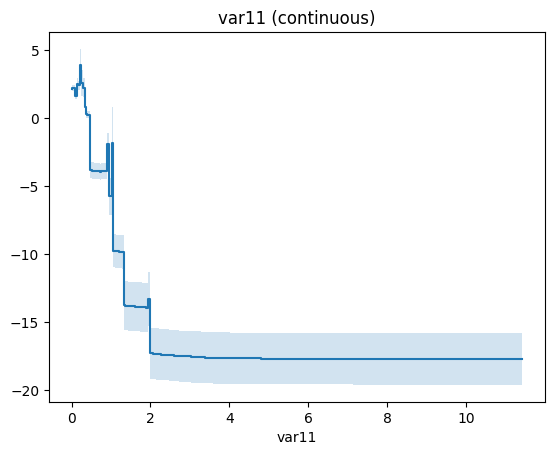

In [12]:
graph = graphs.extract_graph(ebm, 9)
graphs.plot_graph(graph)

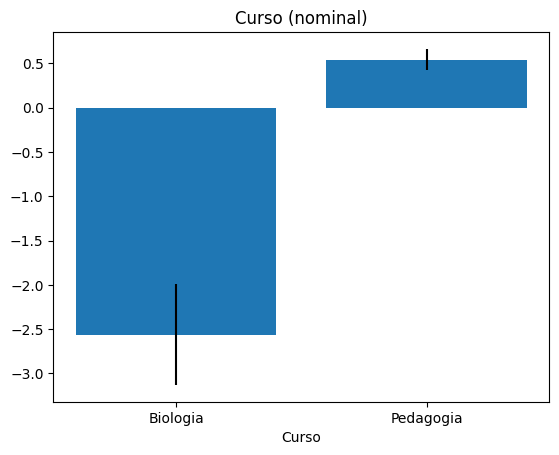

In [13]:
graphs.plot_graph(graphs.extract_graph(ebm, 0))

##### Podemos simplificar gráficos para reduzir o número de tokens


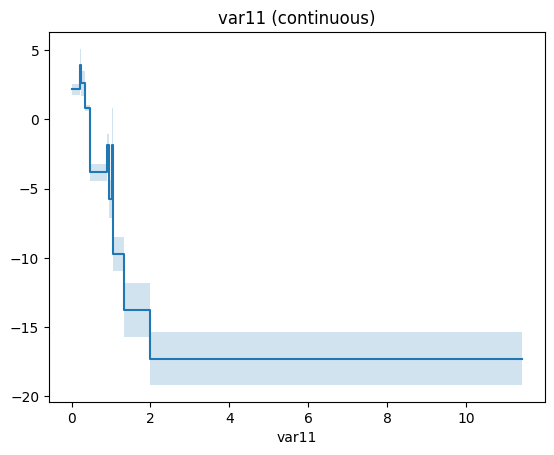

In [14]:
t2ebm.graphs.plot_graph(t2ebm.graphs.simplify_graph(graph, min_variation_per_cent=0.05))

##### É preciso converter gráficos em texto antes de enviá-los ao LLM


In [15]:
graph_as_text = graphs.graph_to_text(graph, max_tokens=1000) # automatically simplifies the graph unitil it satisfies the token limit
print(graph_as_text)

INFO: The graph of feature var11 was simplified by 0.8%.
This graph represents a continuous-valued feature. The keys are intervals that represent ranges where the function predicts the same value.

Feature Name: var11
Feature Type: continuous
Means: {"(0.0, 0.1)": 2.18, "(0.1, 0.135)": 1.61, "(0.135, 0.21000000000000002)": 2.55, "(0.21000000000000002, 0.25)": 3.94, "(0.25, 0.29000000000000004)": 2.6, "(0.29000000000000004, 0.32999999999999996)": 2.26, "(0.32999999999999996, 0.365)": 0.82, "(0.365, 0.48)": 0.28, "(0.48, 0.9)": -3.83, "(0.9, 0.94)": -1.87, "(0.94, 1.02)": -5.73, "(1.02, 1.06)": -1.85, "(1.06, 1.33)": -9.75, "(1.33, 1.94)": -13.76, "(1.94, 2.0)": -13.31, "(2.0, 2.67)": -17.28, "(2.67, 4.325)": -17.48, "(4.325, 11.42)": -17.66}
Lower Bounds (95%-Confidence Interval): {"(0.0, 0.1)": 1.74, "(0.1, 0.135)": 1.17, "(0.135, 0.21000000000000002)": 1.73, "(0.21000000000000002, 0.25)": 1.66, "(0.25, 0.29000000000000004)": 0.76, "(0.29000000000000004, 0.32999999999999996)": 0.93, "(

In [16]:
graph_as_text = graphs.graph_to_text(graphs.extract_graph(ebm, 0))
print(graph_as_text)

This graph represents categorical feature. Each key represents a possible value that the feature can take.

Feature Name: Curso
Feature Type: categorical
Means: {"Biologia": -2.563, "Pedagogia": 0.543}
Lower Bounds (95%-Confidence Interval): {"Biologia": -3.675, "Pedagogia": 0.307}
Upper Bounds (95%-Confidence Interval): {"Biologia": -1.45, "Pedagogia": 0.779}



#### Com a versão textual do gráfico, você pode montá-la em seus próprios prompts


In [18]:
prompt = t2ebm.prompts.describe_graph(graph_as_text,
                                      graph_description="{O eixo y representa o impacto em log-odds sobre a evasão.}",
                                      dataset_description="{Cada linha descreve um(a) aluno(a) em uma disciplina na UPE.}",
                                      task_description="{Resuma o gráfico e destaque como ele se relaciona à evasão.}",)

print(prompt)


Below is the graph of a Generalized Additive Model (GAM). The graph is presented as a JSON object with keys representing the x-axis and values representing the y-axis. For continuous features, the keys are intervals that represent ranges where the function predicts the same value. For categorical features, each key represents a possible value that the feature can take.
    
The graph is provided in the following format:
    - The name of the feature depicted in the graph
    - The type of the feature (continuous, categorical, or boolean)
    - Mean values
    - Lower bounds of confidence interval (optional)
    - Upper bounds of confidence interval (optional)

Here is the graph:

This graph represents categorical feature. Each key represents a possible value that the feature can take.

Feature Name: Curso
Feature Type: categorical
Means: {"Biologia": -2.563, "Pedagogia": 0.543}
Lower Bounds (95%-Confidence Interval): {"Biologia": -3.675, "Pedagogia": 0.307}
Upper Bounds (95%-Confidence

In [ ]:
prompt_leigo = t2ebm.prompts.describe_graph(
    graph_as_text,
    graph_description="{O eixo y representa o impacto em log-odds sobre a evasão.}",
    dataset_description="{Cada linha descreve um(a) aluno(a) em uma disciplina na UPE.}",
    task_description="{Explique para um usuário leigo em ciência de dados, focando nos principais motivos que levam à evasão.}",
    language="Portuguese (Brazil)",
)
print(prompt_leigo)
